In [1]:
# ensure everything is installed
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install tensorflow

In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

2025-06-01 17:57:09.467611: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 17:57:09.565897: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 17:57:09.651540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748793429.723771    5627 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748793429.745741    5627 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748793429.898374    5627 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
# variables for the images, training and the path
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS = 3
EPOCHS = 40

YOUR_PATH = "/home/arson/Downloads/EuroSAT_RGB/EuroSAT"

In [ ]:
# set the dataset
ds = tf.keras.preprocessing.image_dataset_from_directory(
    YOUR_PATH,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 27000 files belonging to 11 classes.


2025-06-01 17:57:13.363561: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
# set the class names
class_names = ds.class_names
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake',
 'model_seq']

2025-06-01 17:57:13.579505: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(32, 64, 64, 3)


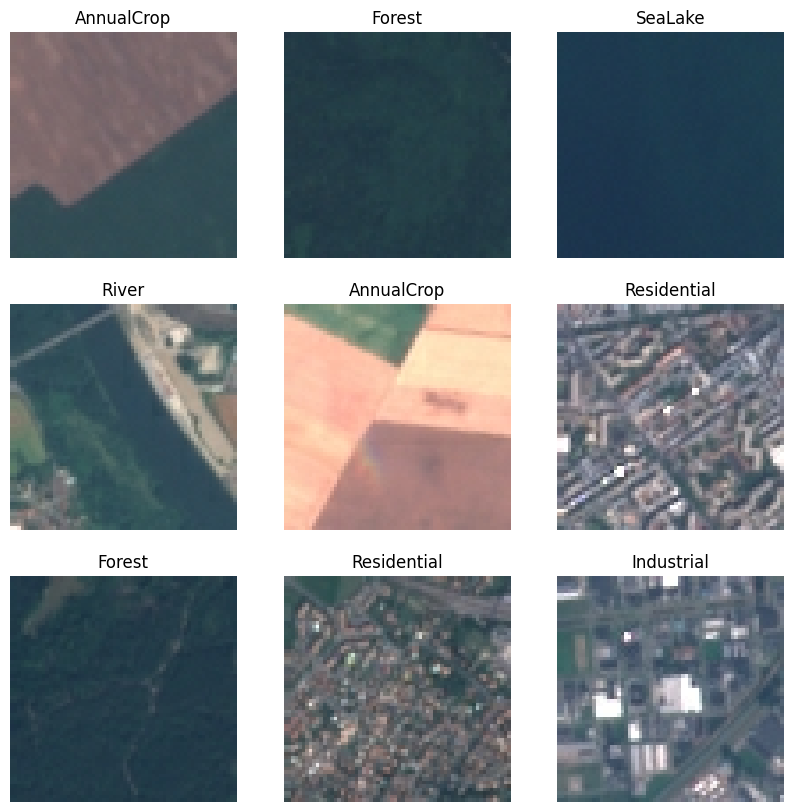

In [ ]:
# plot some example images with their classes, this helps check whether everything waas initialised properly
plt.figure(figsize=(10,10))
for image_batch, label_batch in ds.take(1):
    print(image_batch.shape)
    for i in range(0,9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
# split the dataset, based on how much you want to train and test on
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
# set the training, value and testing dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# preprocessing
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [ ]:
# some slight data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.2),
  layers.RandomZoom(0.2)
])

In [ ]:
# define the sequential model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model_seq = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu',padding='same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',padding='same' ),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model_seq.build(input_shape=input_shape)



/home/arson/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# summarize model
model_seq.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 64, 64, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 64, 64, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 64, 64, 32)       │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 32, 32, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 32, 32, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 16, 16, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 16, 16, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 8, 8, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 8, 8, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 4, 4, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 2, 2, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 1, 1, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,914 (671.54 KB)

 Trainable params: 171,914 (671.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compile the model
model_seq.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# train the sequential model, this may take a long time
history = model_seq.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step - accuracy: 0.2781 - loss: 1.8069 - val_accuracy: 0.5956 - val_loss: 1.1109
Epoch 2/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - accuracy: 0.6018 - loss: 1.0786 - val_accuracy: 0.6682 - val_loss: 0.9402
Epoch 3/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - accuracy: 0.6921 - loss: 0.8426 - val_accuracy: 0.7541 - val_loss: 0.6631
Epoch 4/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 53s 79ms/step - accuracy: 0.7262 - loss: 0.7498 - val_accuracy: 0.7448 - val_loss: 0.7020
Epoch 5/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 49s 73ms/step - accuracy: 0.7626 - loss: 0.6458 - val_accuracy: 0.7809 - val_loss: 0.5983
Epoch 6/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 50s 74ms/step - accuracy: 0.7853 - loss: 0.5888 - val_accuracy: 0.8047 - val_loss: 0.5563
Epoch 7/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 50s 74ms/step - accuracy: 0.8096 - loss: 0.5265 - val_accuracy: 0.8136 - val_loss: 0.5394
Epoch 8/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.8130 - loss: 0.5108 - 

In [ ]:
# this code block is used when loading the pre-trained model
#model_seq.load_weights(f'{YOUR_PATH}/model.weights.h5')

In [16]:
# get model accuracy and loss
test_loss, test_accuracy = model_seq.evaluate(test_ds)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9264 - loss: 0.2122
Test Accuracy: 92.57%
Test Loss: 0.2190


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


2025-06-01 18:31:32.482713: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


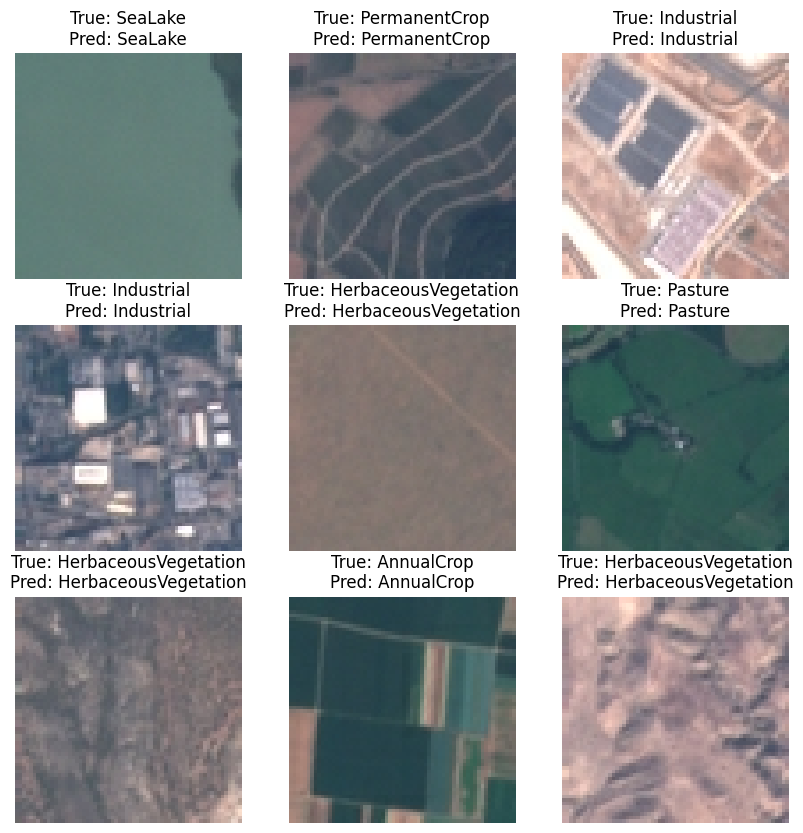

In [17]:
# Test on one of each image, output the true result and the prediction
test_images = test_ds.take(1)
for images, labels in test_images: 
    preds = model_seq.predict(images)
    predicted_classes = np.argmax(preds, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[predicted_classes[i]]}")
        plt.axis("off")

In [ ]:
# I initially made the model sequentially based on https://www.kaggle.com/code/shamikrana/eurosat-cnn-classification/notebook
# for gradcam the model needs to be functional, this saves the model weights which can later be reused in a functional model

# uncomment the next two lines if you want to retrain the model
#model_seq.save_weights(f"{YOUR_PATH}/model.weights.h5")

#model_seq.load_weights(f"{YOUR_PATH}/model.weights.h5")

In [ ]:
# a functional version of the sequential model, this is used so grad-cam and score-cam can be ran on it
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Rescaling, Resizing, RandomFlip, RandomRotation, RandomContrast, RandomZoom
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

x = Resizing(IMAGE_SIZE, IMAGE_SIZE)(inputs)
x = Rescaling(1./255)(x)
x = RandomFlip("horizontal_and_vertical")(x)
x = RandomRotation(0.2)(x)
x = RandomContrast(0.2)(x)
x = RandomZoom(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same', name='last_conv')(x) 
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(n_classes, activation='softmax')(x)

model_func = Model(inputs=inputs, outputs=outputs)

In [ ]:
# compile model, load the model from the previously 
model_func.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# this loads the existing weights, if retraining the model ensure the model_seq.save_weights(f"{YOUR_PATH}/model.weights.h5") line in cell 19 was uncommented and run
model_func.load_weights(f'{YOUR_PATH}/model.weights.h5')

/home/arson/myenv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [25]:
# scoring function
from tf_keras_vis.utils.scores import CategoricalScore
score = CategoricalScore(list(range(10)))

In [26]:
#prepare test images, takes images until all classes are represented
images_by_class = {}
for image, label in test_ds.unbatch().take(1000):
    label_value = int(label.numpy())
    if label_value not in images_by_class:
        images_by_class[label_value] = image.numpy()
    if len(images_by_class) == 10:
        break

X = np.stack([images_by_class[i] for i in sorted(images_by_class.keys())])
X_uint8 = np.clip(X, 0, 255).astype(np.uint8)
true_labels = sorted(images_by_class.keys())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


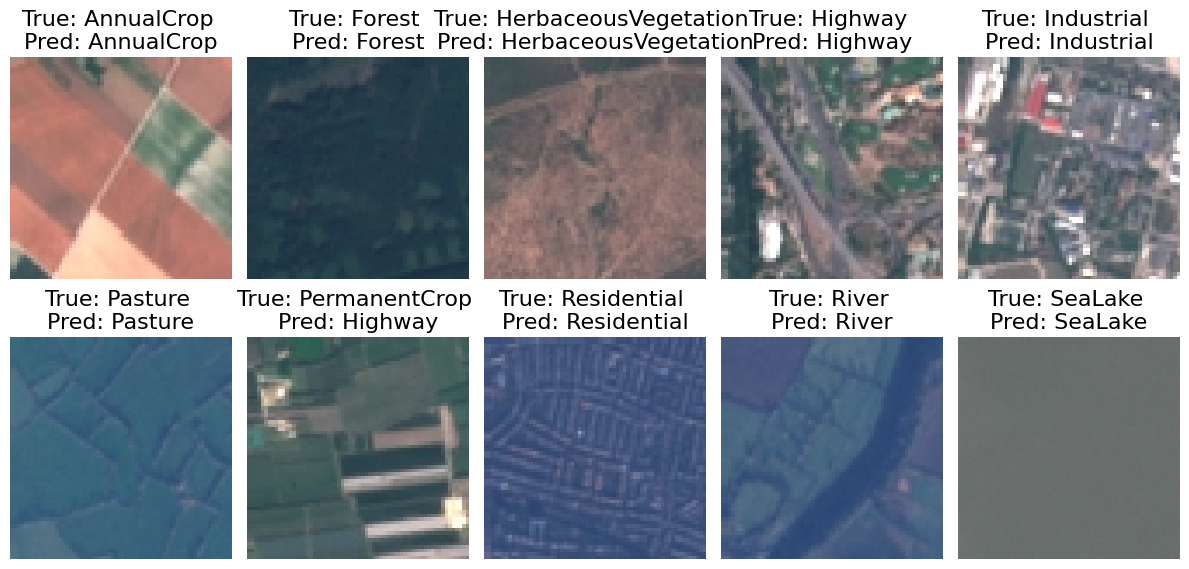

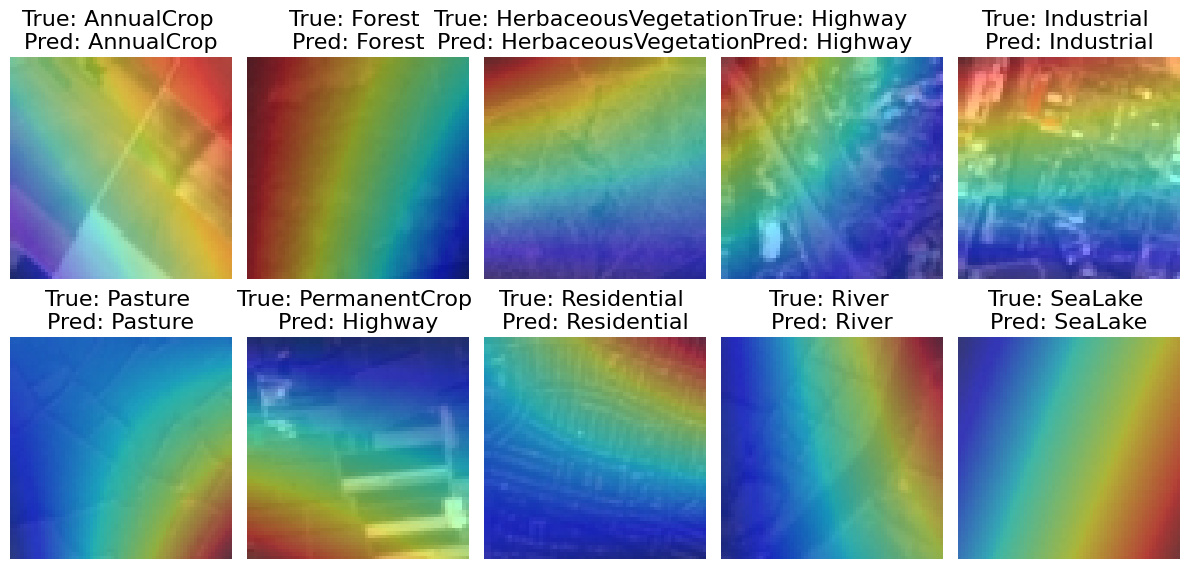

In [35]:
# Gradcam, adapted from NN.ipynb workgroup 6, minor changes such as using uint8 and making sure all 10 classes are shown
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Create Gradcam object
gradcam = Gradcam(model_func,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

image_titles = [class_names[i] for i in range(10)]


preds = model_func.predict(X)
predicted_classes = np.argmax(preds, axis=1)
f, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
ax = ax.flatten()

for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(f"True: {title} \nPred: {class_names[predicted_classes[i]]}", fontsize=16)
    ax[i].imshow(X_uint8[i])
    #ax[i].imshow(heatmap, cmap='jet', alpha=0.3) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

f, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
ax = ax.flatten()
# print the images with the gradcam heatmap overlay
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(f"True: {title} \nPred: {class_names[predicted_classes[i]]}", fontsize=16)
    ax[i].imshow(X_uint8[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Deeplift implementation
#import deeplift
#from deeplift.conversion import kerasapi_conversion as kc
#deeplift_model =\
#    kc.convert_model_from_saved_files(
#        f"{YOUR_PATH}/model_seq.hdf5",
#        nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.DeepLIFT_GenomicsDefault) 

# Initially I wanted to try deeplift, However I could not get it working. as such I chose to work with score-cam/integrated gradient

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


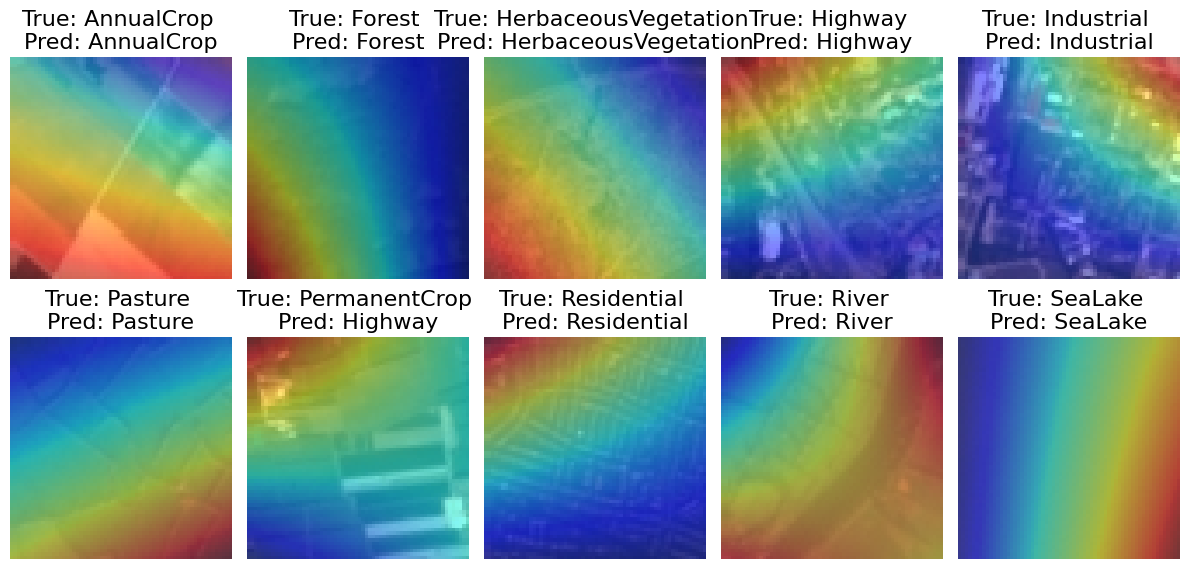

In [34]:
#scorecam implementation
from tf_keras_vis.scorecam import Scorecam

# scorecam, adapted from NN.ipynb workgroup 6, minor changes such as using uint8 and making sure all 10 classes are shown, and obviously replacing the gradcam with scorecam

replace2linear = ReplaceToLinear()

# Create Scorecam object
scorecam = Scorecam(model_func,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with scorecam
cam = scorecam(score,
              X,
              penultimate_layer=-1)

image_titles = [class_names[i] for i in range(10)]


preds = model_func.predict(X)
predicted_classes = np.argmax(preds, axis=1)

f, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
ax = ax.flatten()
# print the images with the scorecam heatmap overlay
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(f"True: {title} \nPred: {class_names[predicted_classes[i]]}", fontsize=16)
    ax[i].imshow(X_uint8[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()